In [22]:
# 모듈 로딩
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim     

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader  # 데이터셋, 데이터로더 생성 
from torch.utils.data import Subset


In [23]:
# 파일 로딩
fish_df = pd.read_csv('fish.csv')

In [24]:
# 결측치 확인 - 없음 
print(fish_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   160 non-null    object 
 1   Weight    160 non-null    float64
 2   Length    160 non-null    float64
 3   Diagonal  160 non-null    float64
 4   Height    160 non-null    float64
 5   Width     160 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB
None


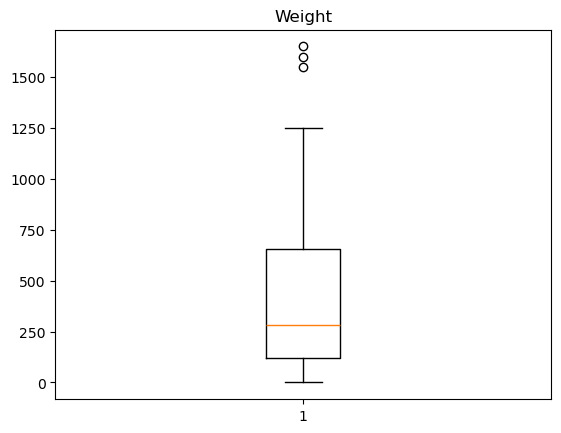

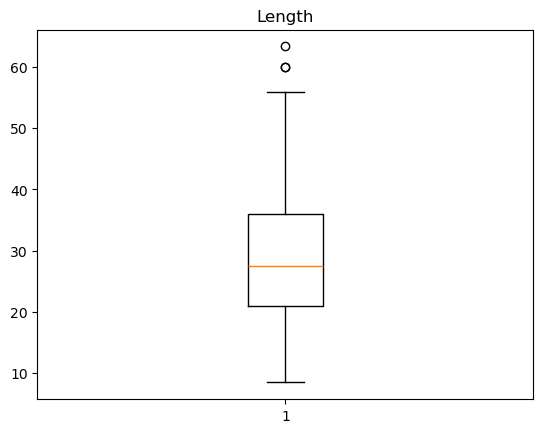

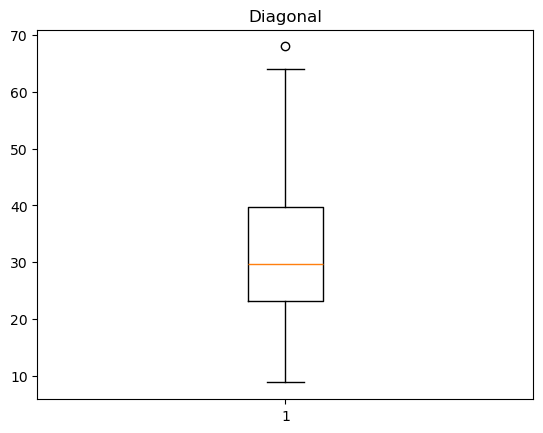

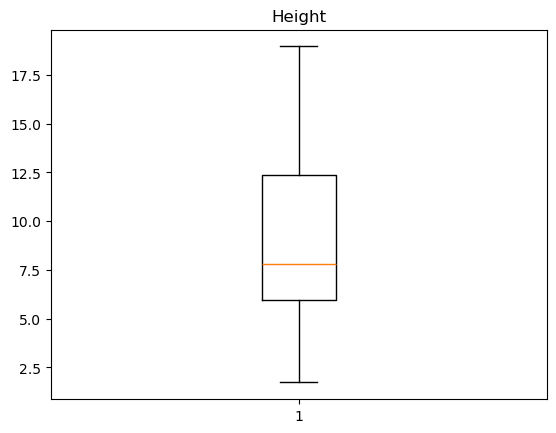

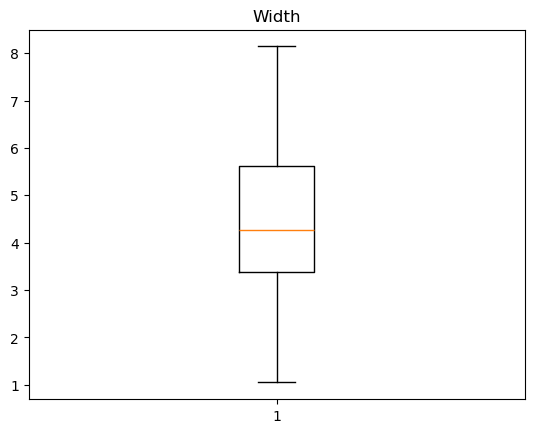

In [25]:
# 이상치 확인 : Weight, Length, Diagonal
for i in fish_df.columns[1:]:
    plt.boxplot(fish_df[i])
    plt.title(i)
    plt.show()

In [26]:
labelToNum={'Bream': 0, 
    'Roach': 1, 
    'Whitefish': 2, 
    'Parkki': 3, 
    'Perch': 4, 
    'Pike': 5, 
    'Smelt': 6}

fish_df['Species'] = fish_df['Species'].map(labelToNum)


print(fish_df['Species'].unique())  

[0 1 2 3 4 5 6]


In [27]:
# 탐색적 분석 - 상관계수 확인 : Height, Width
fish_df.corr()['Species']

Species     1.000000
Weight     -0.179402
Length     -0.120533
Diagonal   -0.211262
Height     -0.697393
Width      -0.316793
Name: Species, dtype: float64

In [28]:
# 피쳐 타겟 분리
featureDF = fish_df[['Height','Width']]
targetSR = fish_df['Species']


In [29]:
# 데이터 불균형 확인
targetSR.value_counts()

Species
4    56
0    35
1    20
5    17
6    14
3    11
2     7
Name: count, dtype: int64

In [41]:
## 전체 데이터 수 체크
print('[전체 데이터 수 체크 ]', featureDF.shape[0])

## 비율 기준 설정
targets = targetSR

## -------(2) 훈련용:검증용:테스트용 데이터 인덱스 추출
## 1단계: 학습용과 검증용 데이터셋 분리
train_indices, valid_indices = train_test_split(range(featureDF.shape[0]),
                                                test_size=0.3, random_state=42, 
                                                stratify=targets)

## 2단계: 검증용 데이터셋을 테스트용 데이터셋 분리
targets = targetSR[valid_indices]
valid_indices, test_indices= train_test_split( valid_indices,
                                               test_size=0.5, random_state=42, 
                                               stratify=targets)

print('train_indices', len(train_indices))
print('valid_indices', len(valid_indices))
print('test_indices', len(test_indices))

# ## -------(3) 훈련용:검증용:테스트용 데이터셋 생성
# trainDS = Subset(imgDS, train_indices)
# validDS = Subset(imgDS, valid_indices)
# testDS = Subset(imgDS, test_indices)

# ## -------(4) 분리 데이터셋의 클래스 비율 체크
# for kind, indices in zip(['Train','Valid','Test'], [trainDS.indices, validDS.indices, testDS.indices]):
#     targets = [ imgDS.targets[ idx ] for idx in indices ]
#     print(f'\n[{kind} 전체 데이터셋 개수 : {len(targets)}개')
#     print(f'        - cat      개수 : {targets.count(0):02}개 {(targets.count(0)/len(targets))*100:.2f}')
#     print(f'        - dog      개수 : {targets.count(1):02}개 {(targets.count(1)/len(targets))*100:.2f}')

[전체 데이터 수 체크 ] 160
train_indices 112
valid_indices 24
test_indices 24


In [45]:
# 클래스 이름 : FishDS
# 부모 클래스 : Dataset
# 필수 메서드 : __init__(self), __len__(self), __getitem__(self,index) 
class FishDS(Dataset):
    # 피쳐와 타겟 저장
    def __init__(self, featureDF, targetSR):
        super().__init__()
        self.feature = featureDF
        self.target = targetSR.to_frame()   # 시리즈를 2차원으로 만들기 (데이터프레임으로 변환)
        
    # 데이터 갯수 반환 메서드
    def __len__(self):
        return self.feature.shape[0]
    
    # 특정 인덱스의 피쳐와 타겟 텐서 반환 메서드
    def __getitem__(self, index):
        # DF -> ndarray -> Tensor
        featureTensor = torch.FloatTensor(self.feature.iloc[index].values)   # 2차원이어야 함
        # SR -> ndarray -> Tensor
        targetTensor = torch.FloatTensor(self.target.iloc[index].values)     # 2차원이어야 함
        
        return featureTensor, targetTensor
        

In [ ]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X[['Height', 'Width']])

StandardScaler()

In [33]:
train_scaled = scaler.transform(train_X[['Height', 'Width']])
test_scaled = scaler.transform(test_X[['Height', 'Width']])

In [34]:
class Fish_Model(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        pass
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
        # output = F.softmax(output, dim=1)  :  CrossEntropy 손실함수 내부에서 softmax가 적용
    
        return output
        

In [35]:
EPOCHS = 50               # 학습용 DS를 처음부터 끝까지 50번 학습
BATCH_SIZE = 128          # 한번에 학습하기 위한 데이터 양
ITERATION = int(train_X.shape[0]/BATCH_SIZE)             # 학습용 DS가 분리된 수 => 1 에포크에 W,b 업데이트 횟수 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정  


LR = 0.001                                           # 학습률 (0.01)
MODEL = Fish_Model(2,128,64,32,7)               # 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   # W,b 초기화, 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.CrossEntropyLoss()                     # 다중분류 손실계산 인스턴스 (계산만 함), 역전파 진행 

In [36]:
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    #for i in range(ITERATION): 
    for feature, target in TRAINDL:
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1).long())
        
        # 정확도 계산

        
        # # 실제 계산하기
        # pre_target = F.softmax(pre_y, dim=1).argmax(dim=1)
        # true_target = target.reshape(-1).long()
        # correct_prediction = pre_target == true_target
        # accuracy = correct_prediction.float().mean()
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()
        E_ACC += acc.item()

    return E_LOSS/ITERATION, E_ACC/ITERATION